In [23]:
import pandas as pd

In [24]:
df = pd.read_csv('./data/merged4.csv')

In [25]:
# Data cleaning: handle nulls and string columns in df
# - Drops columns that are mostly null (e.g. > 80% missing)
# - Fills remaining numeric nulls with median
# - Fills remaining object (string) nulls with mode
# - Label-encodes string columns so they can be used for KNN

import numpy as np
from sklearn.preprocessing import LabelEncoder

# 1. Optionally drop columns with too many nulls
threshold = 0.8  # if >80% values in a column are NaN, drop it
null_ratio = df.isna().mean()
cols_to_drop = null_ratio[null_ratio > threshold].index.tolist()

if cols_to_drop:
    print("Dropping columns with >80% nulls:", cols_to_drop)
    df = df.drop(columns=cols_to_drop)

# 2. Separate numeric and object (string) columns
num_cols = df.select_dtypes(include=["number"]).columns
obj_cols = df.select_dtypes(include=["object", "category"]).columns

# 3. Fill numeric nulls with median
for col in num_cols:
    if df[col].isna().any():
        median_value = df[col].median()
        df[col] = df[col].fillna(median_value)

# 4. Fill string nulls with mode, then label-encode
label_encoders = {}
for col in obj_cols:
    if df[col].isna().any():
        mode_value = df[col].mode().iloc[0]
        df[col] = df[col].fillna(mode_value)

    le = LabelEncoder()
    df[col] = le.fit_transform(df[col].astype(str))
    label_encoders[col] = le

print("Cleaning done. df info after cleaning:")
print(df.info())

Cleaning done. df info after cleaning:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1299 entries, 0 to 1298
Data columns (total 16 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   isbn               1299 non-null   int64  
 1   title              1299 non-null   int64  
 2   publisher          1299 non-null   int64  
 3   publication_date   1299 non-null   int64  
 4   book_format        1299 non-null   int64  
 5   reading_age        1299 non-null   int64  
 6   print_length       1299 non-null   float64
 7   item_weight        1299 non-null   float64
 8   length             1299 non-null   float64
 9   width              1299 non-null   float64
 10  height             1299 non-null   float64
 11  rating             1299 non-null   float64
 12  number_of_reviews  1299 non-null   float64
 13  price              1299 non-null   float64
 14  best_sellers_rank  1299 non-null   float64
 15  customer_reviews   1299 non-null 


=== Target index 0 ===
Neighbor indices: [731 575 367 612 988]
Neighbor distances: [0.04371438 1.6911314  1.88124744 1.90776639 1.90875668]
  -> idx 731, dist 0.04371437791614366
  -> idx 575, dist 1.6911313976046203
  -> idx 367, dist 1.8812474375933192
  -> idx 612, dist 1.9077663852353302
  -> idx 988, dist 1.9087566782683933

=== Target index 5 ===
Neighbor indices: [   5 1261  391  189  687]
Neighbor distances: [5.96046448e-08 5.96046448e-08 5.96046448e-08 5.96046448e-08
 3.31864617e-07]
  -> idx 5, dist 5.960464477539063e-08
  -> idx 1261, dist 5.960464477539063e-08
  -> idx 391, dist 5.960464477539063e-08
  -> idx 189, dist 5.960464477539063e-08
  -> idx 687, dist 3.3186461703956255e-07

=== Target index 10 ===
Neighbor indices: [ 369  181  459   59 1239]
Neighbor distances: [1.08292105 1.22159461 1.33392792 1.5469614  1.57219576]
  -> idx 369, dist 1.0829210482709586
  -> idx 181, dist 1.2215946052327196
  -> idx 459, dist 1.3339279205303862
  -> idx 59, dist 1.546961403806461

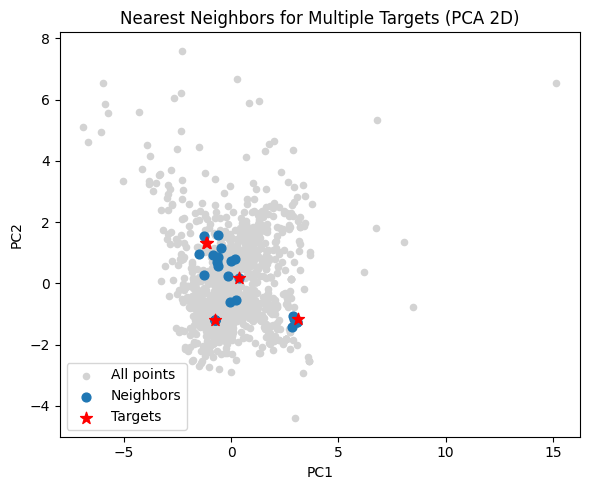

In [26]:
# Nearest neighbors for multiple targets using df (unsupervised) with visualization

from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import NearestNeighbors
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Use all columns in df as features (df is already cleaned above)
X = df.values

# Standardize features so distances are comparable
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Choose the rows you want neighbors for (5 targets)
target_indices = [0, 5, 10, 15, 20]  # change these indices as needed

# Fit NearestNeighbors on all points
n_neighbors = 6  # 1 self + 5 nearest neighbors per target
nn = NearestNeighbors(n_neighbors=n_neighbors, metric="euclidean")
nn.fit(X_scaled)

all_neighbor_indices = set()

for t_idx in target_indices:
    distances, indices = nn.kneighbors(X_scaled[t_idx].reshape(1, -1))
    neighbor_idxs = indices[0][1:]  # exclude self
    neighbor_dists = distances[0][1:]

    print(f"\n=== Target index {t_idx} ===")
    print("Neighbor indices:", neighbor_idxs)
    print("Neighbor distances:", neighbor_dists)
    for idx, d in zip(neighbor_idxs, neighbor_dists):
        print(f"  -> idx {idx}, dist {d}")
    all_neighbor_indices.update(neighbor_idxs)

all_neighbor_indices = sorted(all_neighbor_indices)

# ---- 2D visualization with PCA ----
pca = PCA(n_components=2)
X_2d = pca.fit_transform(X_scaled)

plt.figure(figsize=(6, 5))

# Plot all points in light gray
plt.scatter(X_2d[:, 0], X_2d[:, 1], c="lightgray", s=20, label="All points")

# Plot all neighbor points (union of neighbors)
plt.scatter(X_2d[all_neighbor_indices, 0], X_2d[all_neighbor_indices, 1],
            c="tab:blue", s=40, label="Neighbors")

# Plot all target points
plt.scatter(X_2d[target_indices, 0], X_2d[target_indices, 1],
            c="red", s=80, marker="*", label="Targets")

plt.title("Nearest Neighbors for Multiple Targets (PCA 2D)")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.legend()
plt.tight_layout()
plt.show()